In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns


# 讀取資料

In [2]:
test = pd.read_csv('D:\\AIA\\house_price\\test.csv')
train = pd.read_csv('D:\\AIA\\house_price\\train.csv')
submission = pd.read_csv('D:\\AIA\\house_price\\sample_submission.csv')
print(train.shape)

(1460, 81)


# 資料觀察與處理

首先我們可以觀察一下資料裡房價的分布情況

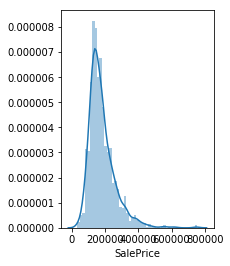

In [3]:
plt.subplot(1,2,1)
SalePrice = sns.distplot(train['SalePrice'])
plt.show()

從上圖可以看出，房價的分布與常態分佈還存在著一定差異我們可以藉由轉換方式使得他更加進常態分佈，在此我們可以對房價做log來做簡易的轉換再作觀察

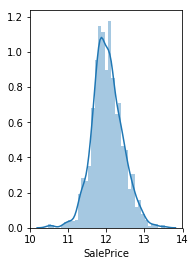

In [4]:
target_price= np.log1p(train['SalePrice'])
plt.subplot(1,2,1)
SalePrice_log= sns.distplot(target_price)
plt.show()

從上圖可以觀察到，房價的分布已經開始接近常態分佈

之後我們可以列出一些感興趣的特徵並觀察其與房價之間的關係

例如，我們可以利用熱力圖觀察各項特徵相互之間的關係

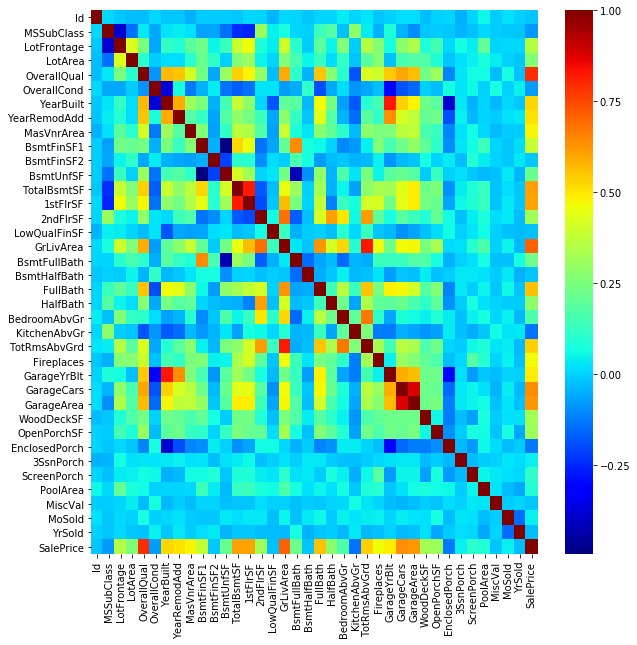

In [5]:
corr_matrix = train.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap="jet")
plt.show()

另外我們也可以個列出單一特徵跟房價之間的關係，讓我們可以更值觀的觀察我們的資料

1.建材與房價之間的關係

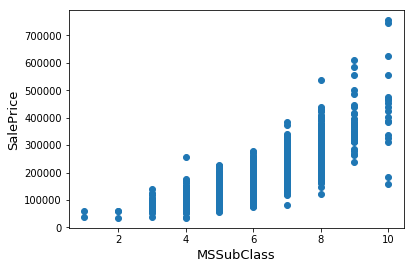

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['OverallQual'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MSSubClass', fontsize=13)
plt.show()

2.占地面積與房價之間的關係

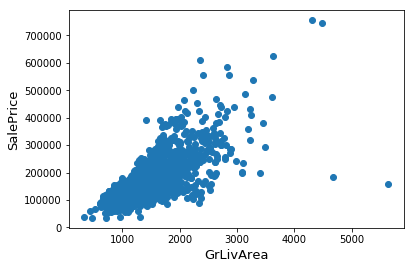

In [7]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

由上圖我們可以發現，資料中出現了一些較為極端的離群值
在此我們可以考慮將這些離群值做剃除，避免訓練時為了擬合這些極端的數值而導致整體預測出現偏差

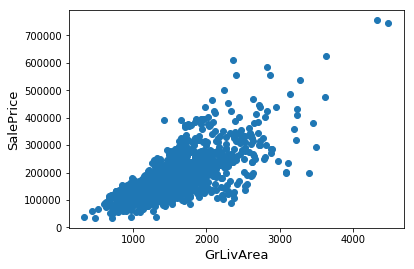

In [8]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

剔除極端值後可以分線房價分布更趨近於線性關係。


觀察完資料後我們可以開始來製作訓練用的dataset

首先，很明顯的ID這項欄位我們完全用不到，所以可以在一開始將其剃除

In [9]:
train.drop("Id", inplace=True, axis=1)
test.drop("Id", inplace=True, axis=1)

In [10]:
y_train = train.SalePrice.values
train.drop("SalePrice", inplace=True, axis=1)

之後我們可以開始處理csv檔中出現的缺值，在這之前我們可以先將test和train先合併取來，如此一來我們便可以一併處理其中的缺值

In [11]:
train_data_number = train.shape[0]
all_data = pd.concat([train, test])
all_data.reset_index(inplace=True, drop=True)
print(all_data.shape)



(2917, 79)


以下是我們偵測到的缺值狀況

In [12]:
data_miss = (all_data.isnull().sum())
data_miss = data_miss.drop(data_miss[data_miss == 0].index)
data_miss

MSZoning           4
LotFrontage      486
Alley           2719
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2908
Fence           2346
MiscFeature     2812
SaleType           1
dtype: int64


偵測到缺值後我們必須根據每項欄位的特性為其補0或者None


In [13]:
all_data["LotFrontage"] = all_data['LotFrontage'].fillna(0)
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
for col in  ('GarageYrBlt', 'GarageArea', 'GarageCars'):all_data[col] = all_data[col].fillna(0)
all_data["FireplaceQu"].fillna("None", inplace=True)
all_data[["GarageCond", "GarageType", "GarageFinish", "GarageQual"]] = all_data[["GarageCond", "GarageType", "GarageFinish", "GarageQual"]].fillna("None")
#train["GarageYrBlt"].fillna(0,  inplace=True)
all_data[["BsmtExposure","BsmtFinType1", "BsmtFinType2", "BsmtCond", "BsmtQual"]] = all_data[["BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtCond", "BsmtQual"]].fillna("None")
all_data[["BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtHalfBath"]] = all_data[["BsmtFullBath", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtHalfBath"]].fillna(0)
all_data["MasVnrArea"].fillna(0, inplace=True)
all_data["MasVnrType"].fillna("None", inplace=True)
most_common = all_data["Electrical"].value_counts().index[0]
all_data["Electrical"].fillna(most_common, inplace=True)
all_data["Functional"].fillna("Typ", inplace=True)
all_data["KitchenQual"].fillna("TA", inplace=True)
most_common =  all_data["SaleType"].value_counts().index[0]
all_data["SaleType"].fillna(most_common, inplace=True)
all_data["Utilities"].fillna("None", inplace=True)
all_data["Exterior1st"].fillna("None", inplace=True)
all_data["Exterior2nd"].fillna("None", inplace=True)
most_common =  all_data["MSZoning"].value_counts().index[0]
all_data["MSZoning"].fillna(most_common, inplace=True)
all_data[['GarageCars']] = all_data[['GarageCars']].fillna(np.mean(train[['GarageCars']]))
all_data[['GarageArea']] = all_data[['GarageArea']].fillna(np.mean(train[['GarageArea']]))
all_data["LotFrontage"] = train.groupby("BldgType")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

之後我們可以針對需要Label Encoding的特徵將其轉換為string的形式

In [14]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

最後我們可以對我們的資料做data skew

雖然我們在一開始觀察資料時就可以對資料中的一些極端值做適當的處理，但當資料維度大到一個程度時就沒有辦法利用人工的方式來做剃除

因此，我們可以為我們的資料做data skew來使的資料分布更接近常態，使得極端值所帶來的影響被抑制

In [16]:
from scipy.stats import norm, skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head()



Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080


In [17]:
skewness = skewness[abs(skewness) > 0.75]
print(skewness.shape[0])

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

32


在將資料送入模型訓練前先對Label做 One Hot encoding

In [18]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 342)


In [19]:
all_datadf_all_d  = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())

最後是對資料做正規化

In [20]:
all_data = (all_data - all_data.mean()) / (all_data.max() - all_data.min())

In [21]:
print(all_data.shape)

(2917, 342)


送進去做訓練之前記得把先前合併而來的資料再次拆成train 與 test

In [22]:
#將剛剛合併的data分成train、test Data#將剛剛合併的d 
df_tr = all_data.iloc[:train_data_number]
df_te = all_data.iloc[train_data_number:]
print(df_tr.shape)
print(df_te.shape)

(1458, 342)
(1459, 342)


In [23]:
y_train = np.log1p(y_train)

# 模型的訓練與預測

在這個部份我們挑選了 Lasso，Ridge，Random Forest以及貝氏分類器來作為我們的預測模型

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def RModel(model_obj, df_tr, df_te, y_train):
    model_obj.fit(df_tr, y_train)
    y_predict = model_obj.predict(df_tr)
    print("rmse:" + str(mean_squared_error(y_train, y_predict)))
    y_te_pred = np.expm1(model_obj.predict(df_te))
    
    return y_te_pred

# Lasso

In [43]:
from sklearn.linear_model import Lasso
print("lasso:")
lr = Lasso(alpha =0.00004, random_state=1)
lasso_score = RModel(lr, df_tr, df_te, y_train)

lasso:
rmse:0.0079645839486981


# Ridge

In [44]:
from sklearn.linear_model import RidgeCV
print ("\nRidgeCV:")
lr=RidgeCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10])
Ridge_score = RModel(lr, df_tr, df_te, y_train)


RidgeCV:
rmse:0.008165642812318918


# Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor
print("RandomForestRegressor:")
lr = RandomForestRegressor()
RForest_score = RModel(lr, df_tr, df_te, y_train)

RandomForestRegressor:
rmse:0.003949297279759799


# BayesianRidge

In [41]:
from sklearn.linear_model import BayesianRidge
print("BayesianRidger:")
lr = BayesianRidge()
y_te_RF = RModel(lr, df_tr, df_te, y_train)

BayesianRidger:
rmse:0.008392799164465312


# 將模型預測結果存成csv

In [47]:
idx = pd.read_csv("D:\\AIA\\house_price\\test.csv").Id
submission = pd.DataFrame({'Id': idx, 'SalePrice': RForest_score})
# you could use any filename. We choose submission here
submission.to_csv('D:\\AIA\\house_price\\submission.csv', index=False)

# Kaggle 得分

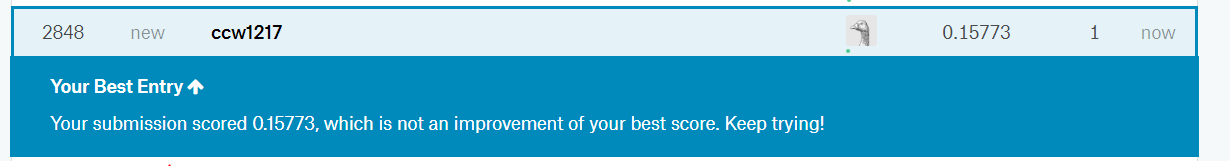